In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score, recall_score

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import itertools
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import warnings
import pandas as pd
from early_stopping import EarlyStopping
import multiprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numbers
import os


# Suppress specific warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide")
warnings.simplefilter(action='ignore', category=FutureWarning)


d:\Conda\envs\YOLO_v8\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basic setup

In [3]:
torch.hub.set_dir('../models')

In [4]:
def get_lr_scheduler(scheduler_name, optimizer, **kwargs):
    """
    Function to get a specific learning rate scheduler instance.

    Args:
        scheduler_name (str): Name of the desired scheduler type.
        optimizer (torch.optim.Optimizer): Optimizer instance.
        **kwargs: Additional keyword arguments to be passed to the scheduler constructor.

    Returns:
        torch.optim.lr_scheduler._LRScheduler: Instance of the specified learning rate scheduler.
    """
    if scheduler_name == 'StepLR':
        return lr_scheduler.StepLR(optimizer, **kwargs)
    elif scheduler_name == 'MultiStepLR':
        return lr_scheduler.MultiStepLR(optimizer, **kwargs)
    elif scheduler_name == 'ExponentialLR':
        return lr_scheduler.ExponentialLR(optimizer, **kwargs)
    elif scheduler_name == 'CosineAnnealingLR':
        return lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, **kwargs)
    elif scheduler_name == 'ReduceLROnPlateau':
        return lr_scheduler.ReduceLROnPlateau(optimizer, **kwargs)
    else:
        raise ValueError(f"Unsupported scheduler name: {scheduler_name}")

In [5]:
def calculate_metrics(epoch,metric_type, loss, labels, predictions):
    return {
        "epoch": [epoch],
        "metric_type": [metric_type],
        "accuracy": [accuracy_score(labels, predictions)],
        "precision": [precision_score(labels, predictions, average="weighted")],
        "recall": [recall_score(labels, predictions, average="weighted")],
        "f1": [f1_score(labels, predictions, average="weighted")],
        "loss" : [loss]
    }

def log_metrics(writer, metrics):
    # Log metrics to TensorBoard
    for key, value in metrics.items():
        if key != "epoch" and key != "metric_type":  # Exclude non-numeric values
            writer.add_scalar(f"{metrics['metric_type'][0]}/{key}", value[0], metrics['epoch'][0] + 1)

def plot_confusion_matrix(y_true, y_pred, classes, output_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(output_path, 'confusion_matrix.jpg'))
    plt.show()

def visualize_metrics(metrics_df, output_path, title):
    # Define the metrics to visualize
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1']

    # Create a grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(12, 6.5))
    axes = axes.flatten()

    # Plot each metric in a subplot
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(data=metrics_df, x='epoch', y=metric, hue='metric_type', style='metric_type', ax=ax)
        ax.set_title(metric.capitalize())
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        #ax.legend(['Train', 'Validation'], loc='best')

    # Adjust layout
    plt.suptitle(f'Training results\n{title}')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'metrics.jpg'))

In [6]:
args = {
    'num_epochs': 10,
    'train_batch_size' : 256,
    'val_batch_size' : 512,
    'num_workers': 8,
    'lr' : 0.001,
    'adam_eps' : 1e-8,
    'adam_beta1' : 0.9,
    'adam_beta2' : 0.999,
    'adam_weight_decay': 0.01,
    'lr_scheduler_type': 'CosineAnnealingLR',

    'es_patience': 3,
    'es_delta': 0,
    'checkpt_steps':2,
}



In [7]:


# Get the number of available CPU cores
num_cores = multiprocessing.cpu_count()
num_cores


12

In [23]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [25]:
#  Load datasets
train_dataset = datasets.ImageFolder('../data/ADHD/slice/train', transform=train_transform)
test_dataset = datasets.ImageFolder('../data/ADHD/slice/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=args['train_batch_size'], shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=args['val_batch_size'], shuffle=False)

In [10]:

def evaluate_model(model, criterion, test_loader, device, output_path):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_test_predictions = []
    all_test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_test_predictions.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    plot_confusion_matrix(all_test_labels, all_test_predictions, classes=test_dataset.classes, output_path=output_path)
    test_metrics = calculate_metrics(1, 'test', test_loss, all_test_labels, all_test_predictions)
    return {k: v[0] for k, v in test_metrics.items() if isinstance(v[0], numbers.Number)}

In [15]:
def train_model(run_name, model, criterion, optimizer, device, args):
    # Tensorboard writer
    timestamped_run_name = (
        f"{run_name}_{datetime.datetime.now()}".replace(":", "_")
        .replace(".", "_")
        .replace(" ", "_")
        .replace('-','_')
    )
    output_path = os.path.join('runs',timestamped_run_name)
    checkpoint_path = os.path.join(output_path, "checkpoints")
    best_checkpt_path = os.path.join(checkpoint_path, "best_checkpoint.pt")

    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    es_checker = EarlyStopping(
        args["es_patience"], True, args["es_delta"], path=best_checkpt_path, save_when_improved=True
    )
    writer = SummaryWriter(output_path)
    metrics_df = pd.DataFrame(
        columns=[
            "epoch",
            "metric_type",
            "loss",
            "accuracy",
            "precision",
            "recall",
            "f1",
        ]
    )

    for epoch in range(args["num_epochs"]):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_predictions = []
        all_train_labels = []

        # Wrap train_loader with tqdm for progress visualization
        train_loader_with_progress = tqdm(
            train_loader, desc=f'Epoch {epoch+1}/{args["num_epochs"]}', leave=False
        )

        for inputs, labels in train_loader_with_progress:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            all_train_predictions.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loader_with_progress.set_postfix(
                {
                    "loss": loss.item(),
                    "acc": (predicted == labels).sum().item() / labels.size(0),
                }
            )

        train_loss = running_loss / len(train_loader)
        train_metrics = calculate_metrics(
            epoch, "train", train_loss, all_train_labels, all_train_predictions
        )

        new_df = pd.DataFrame.from_dict(train_metrics)
        metrics_df = pd.concat([metrics_df, new_df], ignore_index=True)

        log_metrics(writer, train_metrics)

        # Validation
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_predictions = []
        all_val_labels = []
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_val_predictions.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

            val_loss = val_loss / len(test_loader)

        val_metrics = calculate_metrics(
            epoch, "val", val_loss, all_val_labels, all_val_predictions
        )

        new_df = pd.DataFrame.from_dict(val_metrics)
        metrics_df = pd.concat([metrics_df, new_df], ignore_index=True)

        log_metrics(writer, val_metrics)
        
        

        # save checkpoints
        if (epoch + 1) % args["checkpt_steps"] == 0:
            torch.save(
                model.state_dict(),
                os.path.join(checkpoint_path, f"checkpoint_{epoch+1}.pt"),
            )
        print(f"Epoch {epoch+1}/{args['num_epochs']}")
        print()
        print(f'Val. loss: ', val_loss)
        print(f'Val. acc: ', val_metrics['accuracy'])
        print(f'Val. f1: ', val_metrics['f1'])
        
        es_checker(val_loss, model)
        if es_checker.early_stop:
            print("Early stopping")
            break
        print('---------------------------------------------')
        
    # calculate metrics on the test set, and log with the params
    test_metrics = evaluate_model(model, criterion, test_loader, device, output_path)
    writer.add_hparams(args, test_metrics)

    visualize_metrics(metrics_df, output_path, timestamped_run_name)
    metrics_df.to_pickle(os.path.join(output_path, "metrics.pkl"))
    # load the last checkpoint with the best model
    torch.save(model.state_dict(), os.path.join(checkpoint_path, "last_checkpoint.pt"))
    #model.load_state_dict(torch.load(best_checkpt_path)['model_state_dict'])
    
    writer.close()
    return model, metrics_df

## Model creation

### Model class


### Creation

In [16]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model.fc.requires_grad = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=args['lr'])
scheduler = get_lr_scheduler(args["lr_scheduler_type"], optimizer)

d:\Conda\envs\YOLO_v8\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Conda\envs\YOLO_v8\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10

Val. loss:  0.7294617235660553
Val. acc:  [0.5777993213766359]
Val. acc:  [0.46854118429256386]
---------------------------------------------
Validation loss decreased (inf --> 0.729462).  Saving model ...


Epoch 2/10

Val. loss:  0.7610589683055877
Val. acc:  [0.5700436257876879]
Val. acc:  [0.4351667211854078]
---------------------------------------------
EarlyStopping counter: 1 out of 3


Epoch 3/10

Val. loss:  0.6552105784416199
Val. acc:  [0.6136694134755211]
Val. acc:  [0.6136471397130563]
---------------------------------------------
Validation loss decreased (0.729462 --> 0.655211).  Saving model ...


Epoch 4/10

Val. loss:  0.6648101925849914
Val. acc:  [0.6325739214735822]
Val. acc:  [0.6115764443010954]
---------------------------------------------
EarlyStopping counter: 1 out of 3


Epoch 5/10

Val. loss:  0.6437958717346192
Val. acc:  [0.6325739214735822]
Val. acc:  [0.6280875017609282]
---------------------------------------------
Validation loss decreased (0.655211 --> 0.643796).  Saving model ...


Epoch 6/10

Val. loss:  0.6360614061355591
Val. acc:  [0.622879301987397]
Val. acc:  [0.6234461317377392]
---------------------------------------------
Validation loss decreased (0.643796 --> 0.636061).  Saving model ...


Epoch 7/10

Val. loss:  0.6273254990577698
Val. acc:  [0.6054289869122637]
Val. acc:  [0.6038530112476754]
---------------------------------------------
Validation loss decreased (0.636061 --> 0.627325).  Saving model ...


Epoch 8/10

Val. loss:  0.6262951135635376
Val. acc:  [0.6432380029083858]
Val. acc:  [0.6411696233147093]
---------------------------------------------
Validation loss decreased (0.627325 --> 0.626295).  Saving model ...


Epoch 9/10

Val. loss:  0.6234167575836181
Val. acc:  [0.6451769268056229]
Val. acc:  [0.6418620253023121]
---------------------------------------------
Validation loss decreased (0.626295 --> 0.623417).  Saving model ...


Epoch 10/10

Val. loss:  0.6160325884819031
Val. acc:  [0.624818225884634]
Val. acc:  [0.6260014208308722]
---------------------------------------------
Validation loss decreased (0.623417 --> 0.616033).  Saving model ...


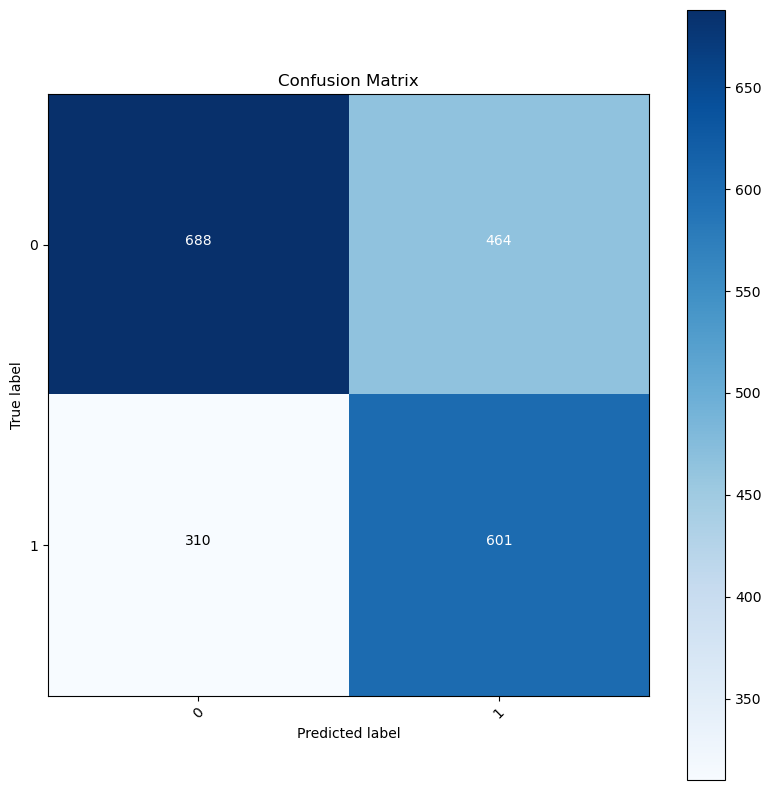

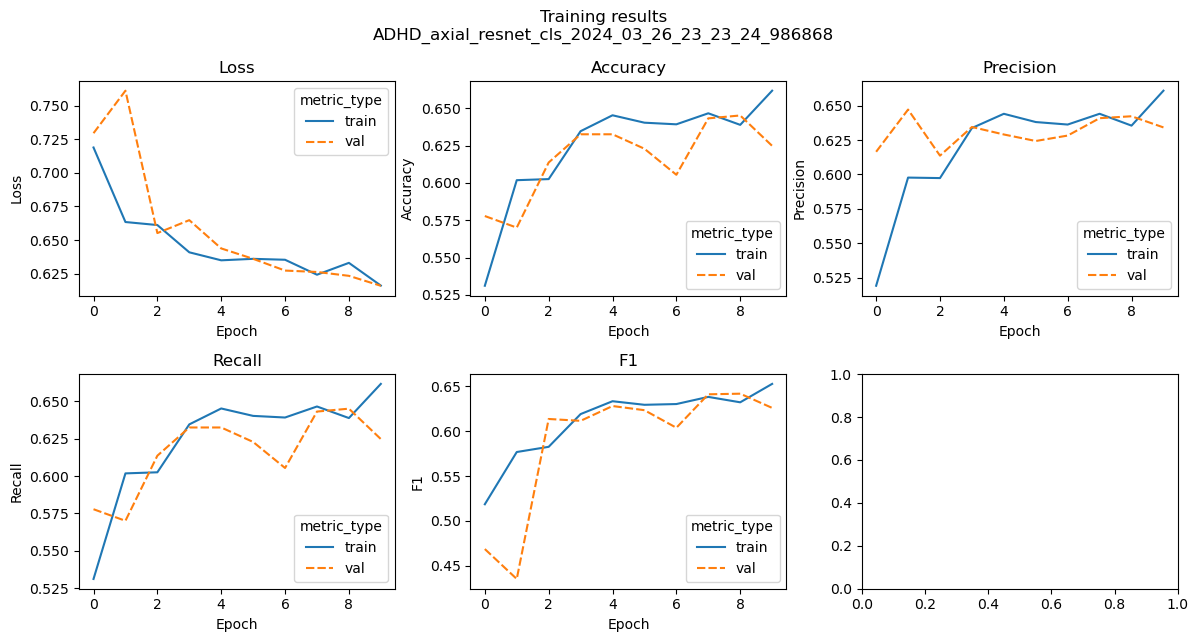

In [17]:
# Train the model
results = train_model(
    model=model,
    run_name='ADHD_axial_resnet_cls',
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    args=args,
)

## Full fine-tune

In [22]:
args = {
    'num_epochs': 10,
    'train_batch_size' : 128,
    'val_batch_size' : 512,
    'num_workers': 8,
    'lr' : 0.00005,
    'adam_eps' : 1e-8,
    'adam_beta1' : 0.9,
    'adam_beta2' : 0.999,
    'adam_weight_decay': 0.01,
    'lr_scheduler_type': 'CosineAnnealingLR',

    'es_patience': 3,
    'es_delta': 0,
    'checkpt_steps':2,
}



In [26]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

model_path = 'runs/ADHD_axial_resnet_cls_2024_03_26_23_23_24_986868/checkpoints/best_checkpoint.pt'
model.load_state_dict(torch.load(model_path))

for param in model.parameters():
    param.requires_grad = True


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=args['lr'])
scheduler = get_lr_scheduler(args["lr_scheduler_type"], optimizer)
es_checker = EarlyStopping(args["es_patience"], True, args["es_delta"], path="best_full_checkpoint.pt")

d:\Conda\envs\YOLO_v8\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Conda\envs\YOLO_v8\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
results = train_model(
    model=model,
    run_name='ADHD_axial_resnet_full',
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    args=args,
)

Epoch 1/10:   0%|          | 0/65 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.65 GiB is allocated by PyTorch, and 216.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Confusion matrix


In [ ]:


# Get predictions for test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy}")

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_predictions, classes=test_dataset.classes)

# Show some results
# You can print some images with their predicted and true labels to visually inspect the performance of the model


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have defined your model, criterion, and test_loader previously
writer = SummaryWriter('runs')
for i in range(5):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_predictions = []
        all_labels = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss /= len(test_loader)
        val_accuracy = val_correct / val_total

    writer.add_scalar('val_loss', val_loss, i)
    #writer.add_scalar('Train/Accuracy', train_accuracy, epoch)

# # Calculate metrics
# metrics = calculate_metrics(all_labels, all_predictions)
# metrics['loss'] = val_loss

# # Convert metrics to DataFrame
# metrics_df = pd.DataFrame(metrics, index=[0])

# print(metrics_df)


In [ ]:
writer = SummaryWriter('runs')
for i in range(10):
    writer.add_scalar('alma', i, i)

writer.flush()
writer.close() 

In [ ]:
%tensorboard 

In [ ]:
import os
os.listdir()

In [ ]:
writer = SummaryWriter('asd')
x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = -5 * x + 0.1 * torch.randn(x.size())

model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

def train_model(iter):
    for epoch in range(iter):
        y1 = model(x)
        loss = criterion(y1, y)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_model(10)
writer.flush()

## Generate plots

In [ ]:
import pandas as pd
import numpy as np

def generate_metrics_data(num_epochs):
    metrics_data = []
    epoch_range = np.arange(1, num_epochs + 1)

    for epoch in epoch_range:
        # Generate train metrics with noise
        train_loss = 1.0 / epoch + np.random.uniform(-0.05, 0.05)
        train_accuracy = (0.8 + 0.02 * epoch) + np.random.uniform(-0.02, 0.02)
        train_precision = (0.75 + 0.02 * epoch) + np.random.uniform(-0.02, 0.02)
        train_recall = (0.85 + 0.01 * epoch) + np.random.uniform(-0.01, 0.01)
        train_f1 = (0.79 + 0.015 * epoch) + np.random.uniform(-0.015, 0.015)

        # Generate validation metrics with noise
        val_loss = train_loss * 0.9 + np.random.uniform(-0.02, 0.02)
        val_accuracy = (train_accuracy * 1.02) + np.random.uniform(-0.02, 0.02)
        val_precision = (train_precision * 1.01) + np.random.uniform(-0.02, 0.02)
        val_recall = (train_recall * 1.01) + np.random.uniform(-0.01, 0.01)
        val_f1 = (train_f1 * 1.015) + np.random.uniform(-0.015, 0.015)

        # Append train metrics
        metrics_data.append({'epoch': epoch, 'metric_type': 'train', 'loss': train_loss,
                             'accuracy': train_accuracy, 'precision': train_precision,
                             'recall': train_recall, 'f1': train_f1})

        # Append validation metrics
        metrics_data.append({'epoch': epoch, 'metric_type': 'val', 'loss': val_loss,
                             'accuracy': val_accuracy, 'precision': val_precision,
                             'recall': val_recall, 'f1': val_f1})

    metrics_df = pd.DataFrame(metrics_data)
    return metrics_df




In [ ]:
# Example usage:
num_epochs = 50
metrics_df = generate_metrics_data(num_epochs)

In [ ]:
"""Create a function that takes this kind of daataframe and makes a visualisation out of this. It should create a grid wiht 3 columns and 2 rows. Each cell in the grid should have a plot of a metric listed in the df. (loss, accuracy, precision, recall f1). In each cell the corresponding metric should be visualized with a lineplot, both the train and the val type of metric in the same cell. Make the have a legend, with a train_ or val_ prefix."""